In [34]:
import warnings
warnings.simplefilter(action='ignore')

In [35]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

In [224]:
sc.set_figure_params(dpi=100, figsize=(4, 4), frameon=False)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### loading the raw data forb both ref and query

In [38]:
adata = sc.read('./covid_raw_sergey.h5ad')

In [39]:
adata.obs.condition2.value_counts()

control (refrence)           154723
severe COVID-19 (query)       36073
control (query)               19137
moderate COVID-19 (query)      7259
Name: condition2, dtype: int64

In [40]:
adata = adata[~adata.obs['study'].isin(['Villani', 'HCL'])].copy()

In [41]:
adata.obs.study.value_counts()

COVID-19 (query)                     62469
Northwestern_Misharin_2018Reyfman    35447
Sanger_Meyer_2019Madissoon           34407
10X                                  10727
Krasnow_distal 3                     10291
Krasnow_distal 2                      6129
Krasnow_distal 1a                     4675
Krasnow_proximal 3                    4248
Krasnow_medial 2                      3981
Oetjen_U                              3730
Freytag                               3347
Oetjen_P                              3265
Oetjen_A                              2586
Sun_sample4_TC                        2420
Sun_sample3_TB                        2403
Sun_sample2_KC                        2281
Sun_sample1_CS                        1725
Name: study, dtype: int64

In [42]:
sca.add_annotations(adata, '../metadata/c2.cp.reactome.v4.0.symbols.gmt', min_genes=12)

Subsetig the query data 

In [43]:
query = adata[adata.obs['study'].isin(['COVID-19 (query)'])].copy()

In [44]:
adata = adata[~adata.obs['study'].isin(['COVID-19 (query)'])].copy()

In [45]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [46]:
adata.layers["counts"] = adata.X.copy()

In [47]:
sc.pp.normalize_total(adata)

In [48]:
sc.pp.log1p(adata)

In [49]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    batch_key="study",
    subset=True)

Selecting terms with >12 genees

In [50]:
select_terms = adata.varm['I'].sum(0)>12

In [51]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [52]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [53]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [54]:
adata.X = adata.layers["counts"].copy()

In [55]:
adata.obs.study.value_counts()

Northwestern_Misharin_2018Reyfman    35447
Sanger_Meyer_2019Madissoon           34407
10X                                  10727
Krasnow_distal 3                     10291
Krasnow_distal 2                      6129
Krasnow_distal 1a                     4675
Krasnow_proximal 3                    4248
Krasnow_medial 2                      3981
Oetjen_U                              3730
Freytag                               3347
Oetjen_P                              3265
Oetjen_A                              2586
Sun_sample4_TC                        2420
Sun_sample3_TB                        2403
Sun_sample2_KC                        2281
Sun_sample1_CS                        1725
Name: study, dtype: int64

In [56]:
adata.obs.condition2

P1_3_TAAGAGAGTGAAGGCT_Krasnow-0-0-1-1-0-2-0    control (refrence)
P2_1_CTACCCAAGATAGCAT_Krasnow-0-0-1-1-0-2-0    control (refrence)
P3_5_AACTGGTCACATGACT_Krasnow-0-0-1-1-0-2-0    control (refrence)
P2_7_GAATGAAGTCGGATCC_Krasnow-0-0-1-1-0-2-0    control (refrence)
P3_4_CATTCGCAGCTAAACA_Krasnow-0-0-1-1-0-2-0    control (refrence)
                                                      ...        
TTTGTCACACCAGATT-1-Oetjen_U-1-1-1-1-0-0-4      control (refrence)
TTTGTCACACCCAGTG-1-Oetjen_U-1-1-1-1-0-0-4      control (refrence)
TTTGTCACATCGACGC-1-Oetjen_U-1-1-1-1-0-0-4      control (refrence)
TTTGTCACATTGAGCT-1-Oetjen_U-1-1-1-1-0-0-4      control (refrence)
TTTGTCATCCTACAGA-1-Oetjen_U-1-1-1-1-0-0-4      control (refrence)
Name: condition2, Length: 131662, dtype: category
Categories (1, object): ['control (refrence)']

### Create the model and train it on reference dataset

In [126]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[545, 545],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False,
    mmd_instead_kl=False,
    use_l_encoder=True,)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 5000 545 16
	Hidden Layer 1 in/out: 545 545
	Mean/Var Layer in/out: 545 545
Encoder Architecture:
	Input Layer in, out and cond: 5000 128 16
	Mean/Var Layer in/out: 128 1
Decoder Architecture:
	Masked linear layer in, out and cond:  545 5000 16


In [127]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
ALPHA = 0.7
EPOCHS = 400

In [128]:

intr_cvae.train(
    n_epochs=EPOCHS, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=None,
    alpha_kl=0.25,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2020)

 |██████████████████--| 92.8%  - epoch_loss: 1938.01 - epoch_recon_loss: 1885.94 - epoch_kl_loss:  208.26 - val_loss: 2017.89 - val_recon_loss: 1967.06 - val_kl_loss:  203.359
ADJUSTED LR
 |███████████████████-| 98.0%  - epoch_loss: 1941.39 - epoch_recon_loss: 1889.15 - epoch_kl_loss:  208.95 - val_loss: 2015.55 - val_recon_loss: 1964.62 - val_kl_loss:  203.69
ADJUSTED LR
 |████████████████████| 100.0%  - epoch_loss: 1935.74 - epoch_recon_loss: 1883.60 - epoch_kl_loss:  208.56 - val_loss: 2015.42 - val_recon_loss: 1964.53 - val_kl_loss:  203.52
Saving best state of network...
Best State was in Epoch 398


In [129]:

inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


['EXTRINSIC_PATHWAY_FOR_APOPTOSI',
 'SYNTHESIS_OF_BILE_ACIDS_AND_BI',
 'METABOLISM_OF_STEROID_HORMONES',
 'SIGNALING_BY_NODAL',
 'SPRY_REGULATION_OF_FGF_SIGNALI',
 'ABCA_TRANSPORTERS_IN_LIPID_HOM',
 'REGULATION_OF_KIT_SIGNALING',
 'ACTIVATED_AMPK_STIMULATES_FATT',
 'TERMINATION_OF_O_GLYCAN_BIOSYN',
 'SIGNALING_BY_CONSTITUTIVELY_AC',
 'ASSOCIATION_OF_LICENSING_FACTO',
 'PROLONGED_ERK_ACTIVATION_EVENT',
 'P38MAPK_EVENTS',
 'HS_GAG_DEGRADATION',
 'ACYL_CHAIN_REMODELLING_OF_PC',
 'SYNTHESIS_OF_PIPS_AT_THE_GOLGI',
 'ACTIVATED_POINT_MUTANTS_OF_FGF',
 'SYNTHESIS_OF_PA',
 'HYALURONAN_METABOLISM',
 'HS_GAG_BIOSYNTHESIS',
 'APOPTOSIS_INDUCED_DNA_FRAGMENT',
 'ACYL_CHAIN_REMODELLING_OF_PE',
 'A_TETRASACCHARIDE_LINKER_SEQUE',
 'GLUTAMATE_NEUROTRANSMITTER_REL',
 'TIE2_SIGNALING',
 'P75NTR_SIGNALS_VIA_NFKB',
 'XENOBIOTICS',
 'HDL_MEDIATED_LIPID_TRANSPORT',
 'NRIF_SIGNALS_CELL_DEATH_FROM_T',
 'REGULATION_OF_BETA_CELL_DEVELO',
 'NEUROTRANSMITTER_RELEASE_CYCLE',
 'ENDOGENOUS_STEROLS',
 'REGULATION_OF_GE

### Visaulizing the reference 

In [130]:
MEAN = False

In [131]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(adata.X.A, adata.obs['study'].tolist(),mean=MEAN)[:, ~inactive_idx]

In [132]:
ref_ss= sc.pp.subsample(adata, copy=True, fraction=0.2)

In [133]:
sc.pp.neighbors(ref_ss, use_rep='X_cvae')

In [134]:
sc.tl.umap(ref_ss)

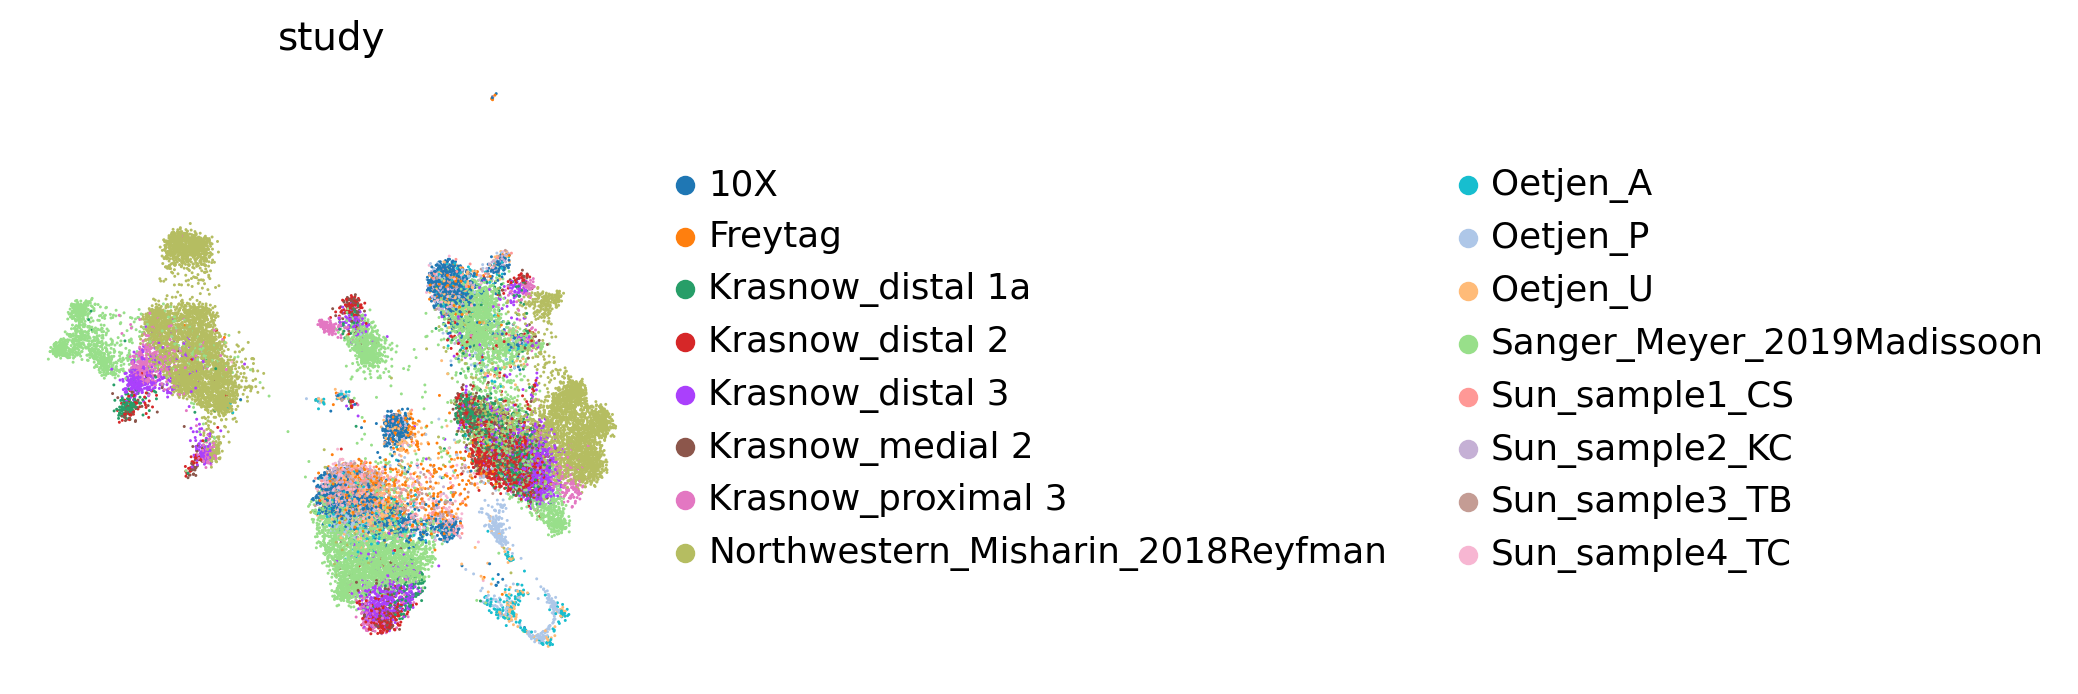

In [135]:
sc.pl.umap(ref_ss, color=['study'], frameon=False)

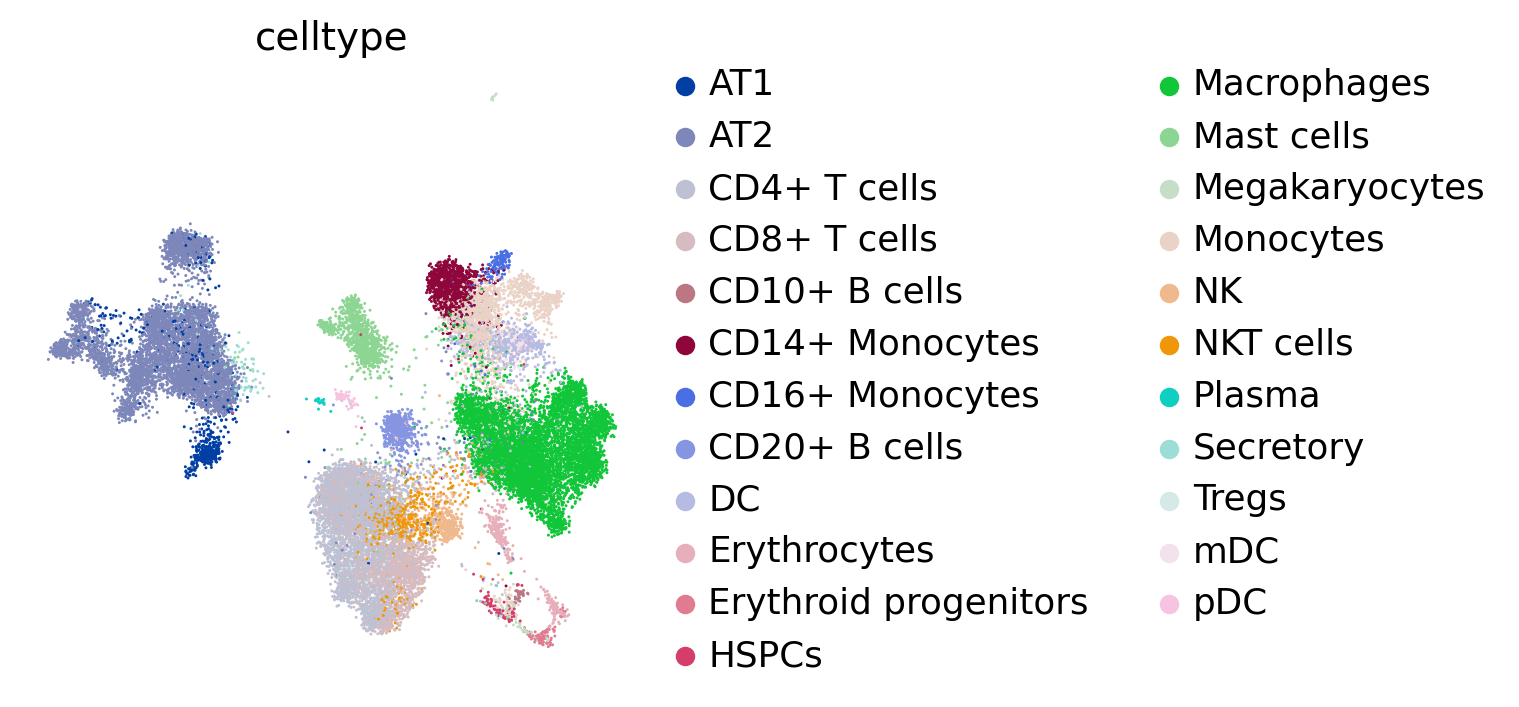

In [136]:
sc.pl.umap(ref_ss, color=['celltype'], frameon=False)

In [137]:
##### saving the model

In [141]:
name = "reference_covid_5k_new_3"

In [142]:
intr_cvae.save(name)

In [143]:
query = query[:, adata.var_names].copy()

In [144]:
#q_intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nb_alpha_kl_0_001_sd_2021', kang)

In [145]:
query.obs.sample_new.value_counts()

S2     16474
S1     11693
HC1     8429
HC2     8153
M1      3517
M2      3386
S6      2868
HC3     2555
S5      2041
S4      1705
S3      1292
M3       356
Name: sample_new, dtype: int64

#### Query training

In [155]:
query.obs.study = query.obs.sample_new.copy()

In [156]:
q_intr_cvae = sca.models.TRVAE.load_query_data(query, name)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 5000 545 28
	Hidden Layer 1 in/out: 545 545
	Mean/Var Layer in/out: 545 545
Encoder Architecture:
	Input Layer in, out and cond: 5000 128 28
	Mean/Var Layer in/out: 128 1
Decoder Architecture:
	Masked linear layer in, out and cond:  545 5000 28


In [148]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
ALPHA = 0.5
EPOCHS = 400

In [157]:
q_intr_cvae.train(n_epochs=300, alpha_epoch_anneal=50, weight_decay=0.0,
                  alpha_kl=0.05, seed=2020,    alpha=None, 
 use_early_stopping=True, 
                  early_stopping_kwargs=early_stopping_kwargs)


 |████████------------| 44.7%  - epoch_loss: 2210.20 - epoch_recon_loss: 2195.66 - epoch_kl_loss:  290.92 - val_loss: 2017.96 - val_recon_loss: 2003.60 - val_kl_loss:  287.25
ADJUSTED LR
 |██████████----------| 52.0%  - epoch_loss: 2216.90 - epoch_recon_loss: 2202.33 - epoch_kl_loss:  291.40 - val_loss: 2017.90 - val_recon_loss: 2003.54 - val_kl_loss:  287.28
ADJUSTED LR
 |███████████---------| 59.3%  - epoch_loss: 2205.39 - epoch_recon_loss: 2190.85 - epoch_kl_loss:  290.89 - val_loss: 2017.80 - val_recon_loss: 2003.44 - val_kl_loss:  287.28
ADJUSTED LR
 |████████████--------| 63.7%  - epoch_loss: 2210.71 - epoch_recon_loss: 2196.16 - epoch_kl_loss:  290.95 - val_loss: 2016.97 - val_recon_loss: 2002.61 - val_kl_loss:  287.24
ADJUSTED LR
 |█████████████-------| 68.3%  - epoch_loss: 2220.93 - epoch_recon_loss: 2206.36 - epoch_kl_loss:  291.50 - val_loss: 2017.36 - val_recon_loss: 2003.00 - val_kl_loss:  287.28
ADJUSTED LR
 |██████████████------| 72.7%  - epoch_loss: 2206.81 - epoch_reco

In [181]:
q_intr_cvae.save("reference_covid_5k_new_3+query")

#### Latent space for query data 

In [158]:
query.obsm['X_cvae'] = q_intr_cvae.get_latent(query.X.A, query.obs.study, mean=MEAN)[:, ~inactive_idx]

In [159]:
q_ss= sc.pp.subsample(query, copy=True, fraction=0.2)

In [160]:
sc.pp.neighbors(q_ss, use_rep='X_cvae')

In [161]:
sc.tl.umap(q_ss)

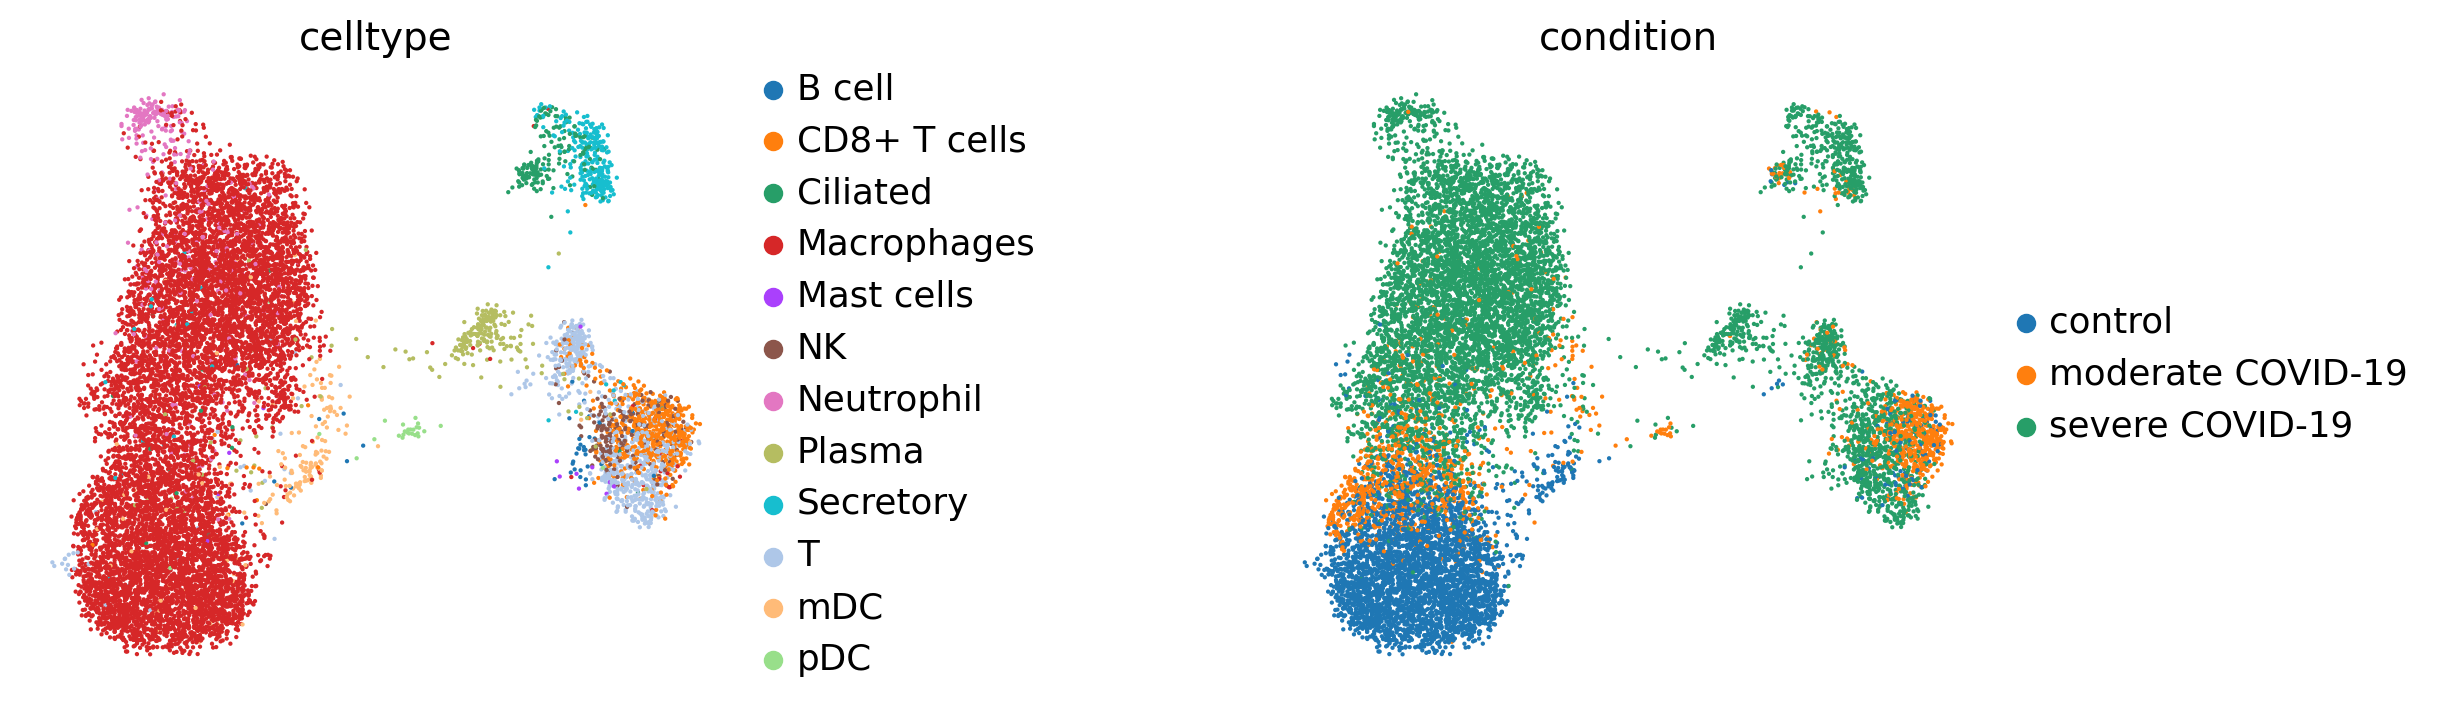

In [162]:
sc.pl.umap(q_ss, color=['celltype', 'condition'], frameon=False, wspace=0.6)

#### Joint embedding of query and the reference 

In [163]:
adata_all = sc.AnnData.concatenate(query, adata, batch_key='batch_join')

In [164]:
adata_all.obsm['X_cvae'] = q_intr_cvae.get_latent(adata_all.X.A, adata_all.obs['study'].tolist(), mean=MEAN)[:, ~inactive_idx]

In [165]:
sc.pp.neighbors(adata_all, use_rep='X_cvae')
sc.tl.umap(adata_all)

... storing 'age_range' as categorical
... storing 'anatomical_region' as categorical
... storing 'batch' as categorical
... storing 'dataset' as categorical
... storing 'donor' as categorical
... storing 'ethnicity' as categorical
... storing 'last_author/PI' as categorical
... storing 'lung_vs_nasal' as categorical
... storing 'original_celltype_ann' as categorical
... storing 'pack_years' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'smoking' as categorical
... storing 'ann_level_1' as categorical
... storing 'ann_level_2' as categorical
... storing 'ann_level_3' as categorical
... storing 'ann_level_4' as categorical
... storing 'ann_level_5' as categorical
... storing 'ann_new' as categorical
... storing 'subject_type' as categorical
... storing 'study' as categorical
... storing 'study2' as categorical
... storing 'celltype' as categorical
... storing 'condition' as categorical
... storing 'ID' as categorical
... storing 'sample_

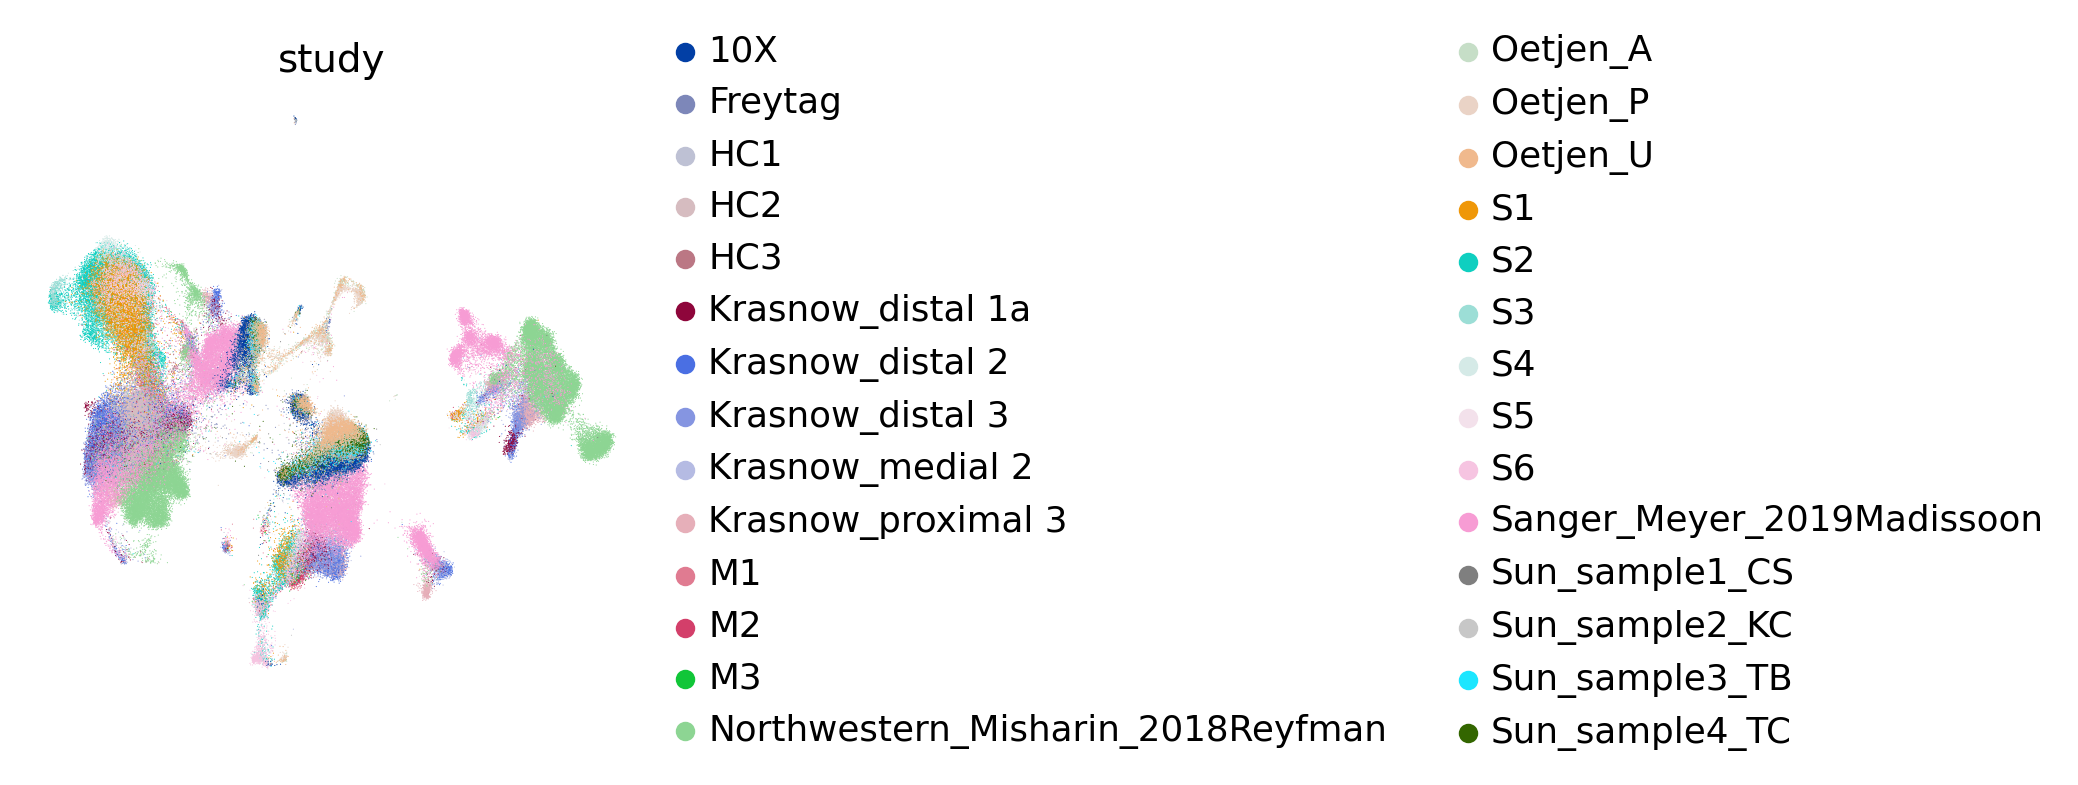

In [166]:
sc.pl.umap(adata_all, color=['study'], frameon=False, wspace=0.6)

In [167]:
adata_all.obs.condition2.value_counts()

control (refrence)           131662
severe COVID-19 (query)       36073
control (query)               19137
moderate COVID-19 (query)      7259
Name: condition2, dtype: int64

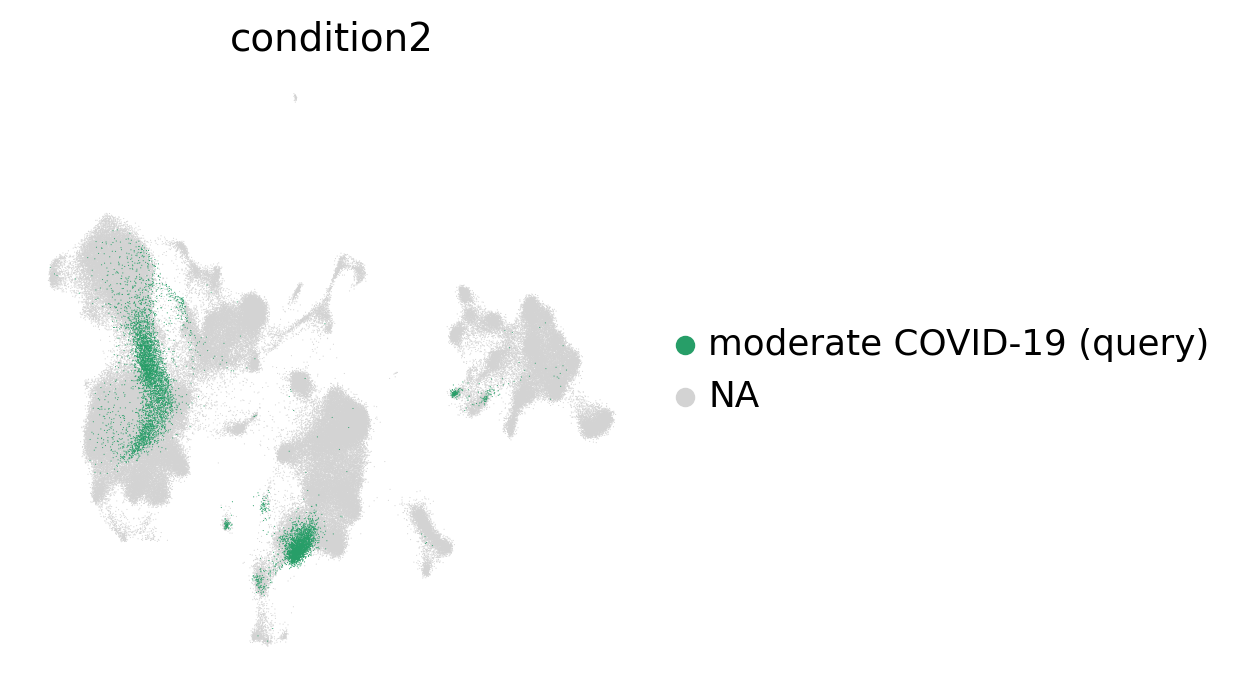

In [168]:
sc.pl.umap(adata_all, color=['condition2'], groups=["moderate COVID-19 (query)"], frameon=False, wspace=0.6)

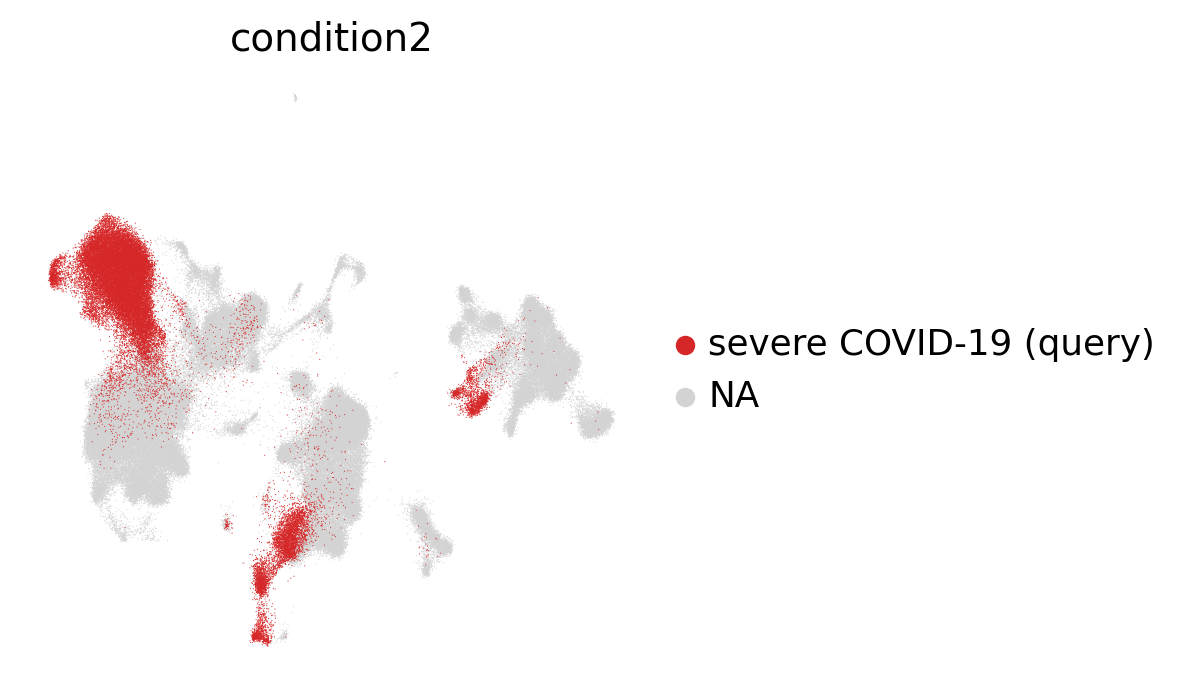

In [169]:
sc.pl.umap(adata_all, color=['condition2'], groups=["severe COVID-19 (query)"], frameon=False, wspace=0.6)

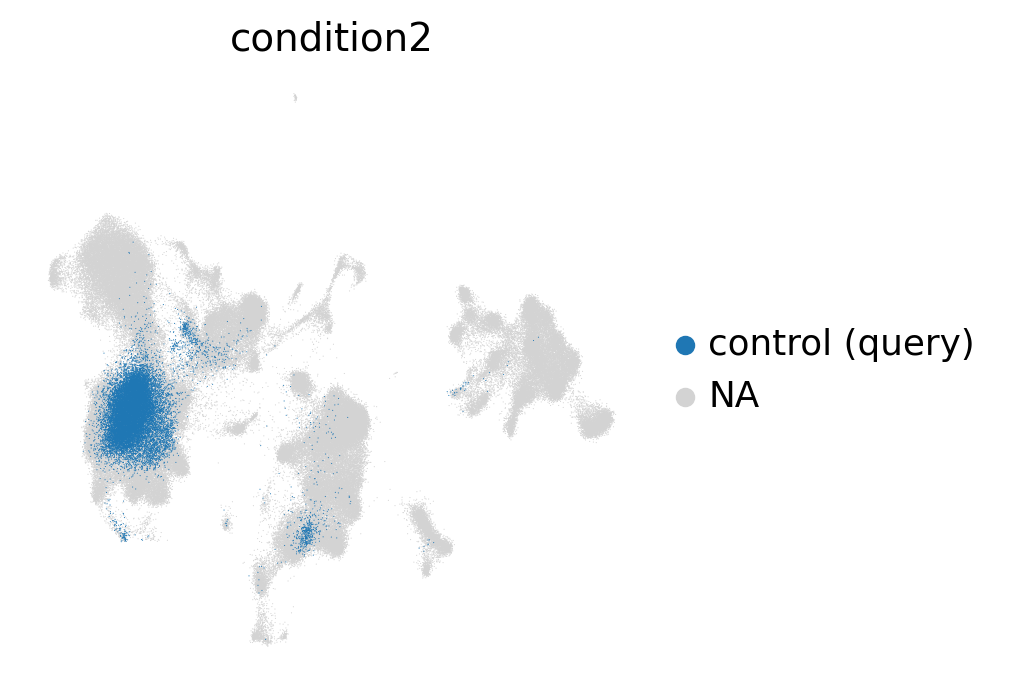

In [170]:
sc.pl.umap(adata_all, color=['condition2'], groups=["control (query)"], frameon=False, wspace=0.6)

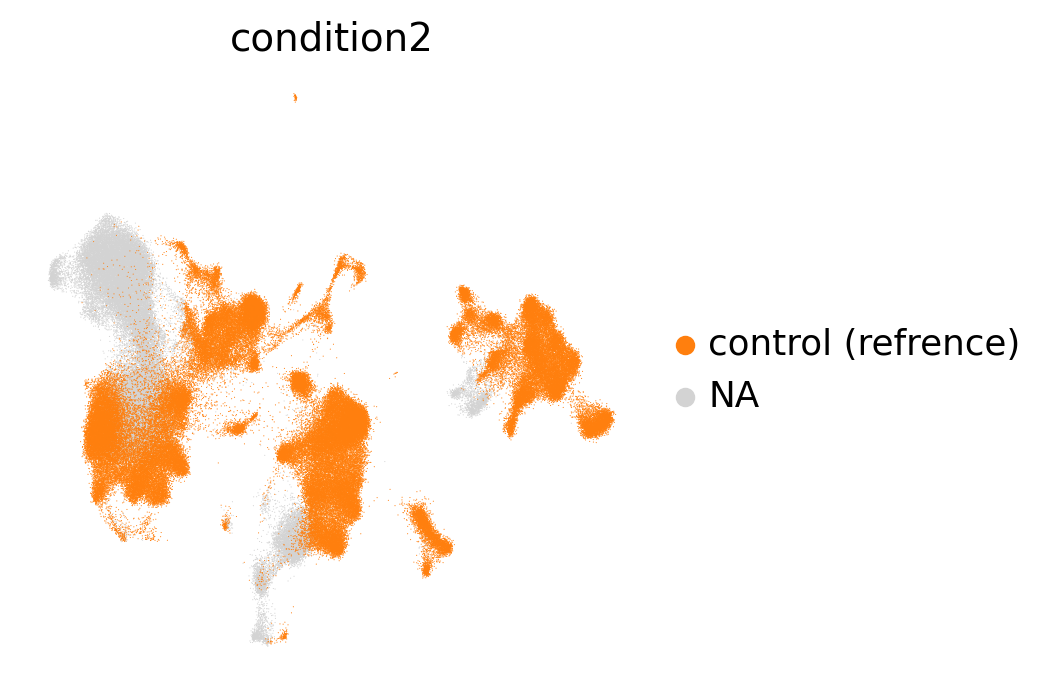

In [172]:
sc.pl.umap(adata_all, color=['condition2'], groups=["control (refrence)"], frameon=False, wspace=0.6)

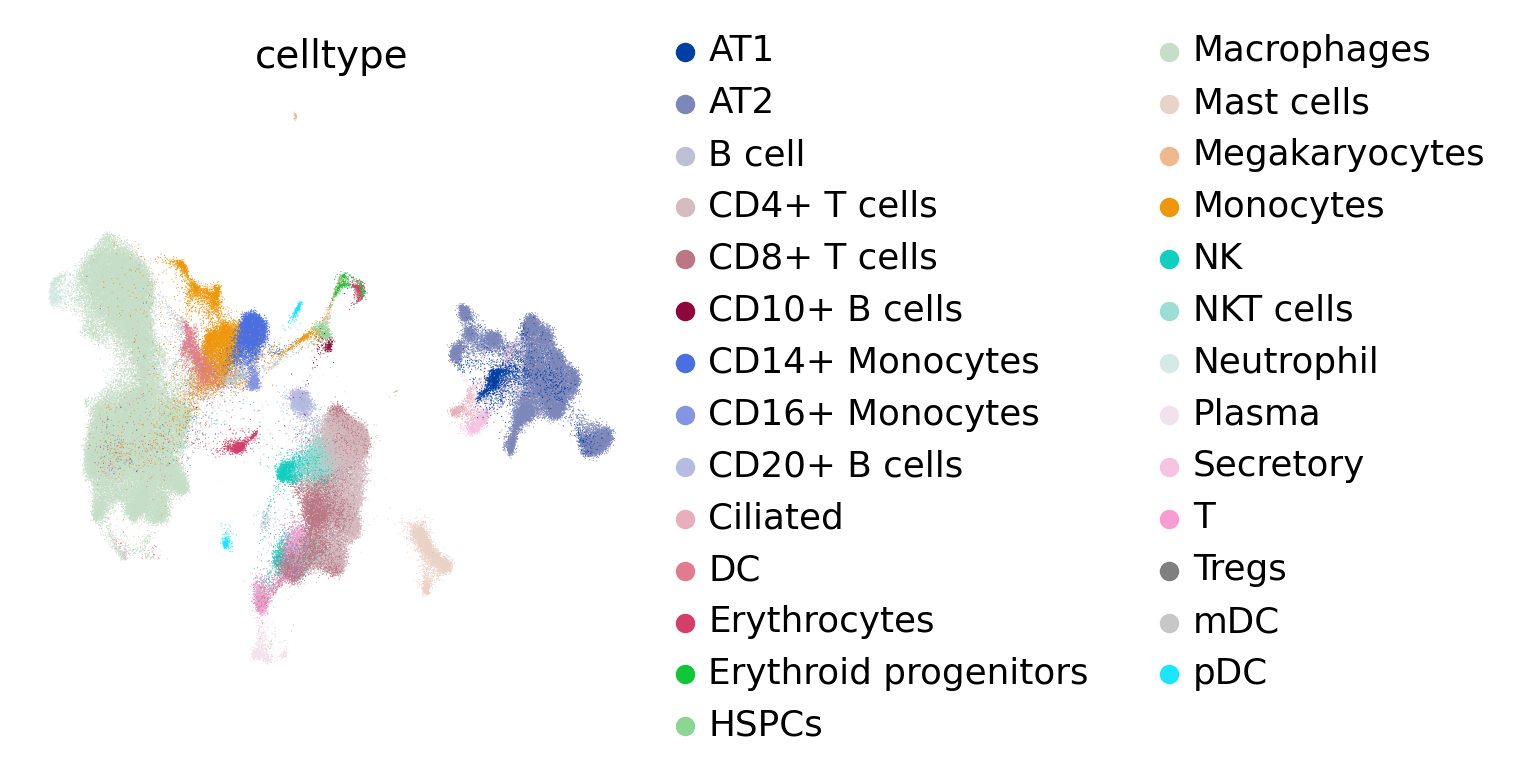

In [173]:
sc.pl.umap(adata_all, color=['celltype'], frameon=False, wspace=0.6)

### Diffrerential enrichment analysis

In [265]:
adata_all.obs.condition2 = adata_all.obs.condition2.astype('category')
adata_all.obs.condition = adata_all.obs.condition.astype('category')

In [266]:
adata_all.uns["terms"] = np.array(adata_all.uns["terms"])
adata_all.uns["active_terms"] = np.array(adata_all.uns["active_terms"])
adata_all.uns['active_terms'] = np.array(adata_all.uns['terms'])[q_intr_cvae.model.decoder.nonzero_terms()]

setting directions

In [267]:
directions = q_intr_cvae._latent_directions(method="sum")

In [268]:
adata_all.obsm['X_cvae'] *= directions[q_intr_cvae.model.decoder.nonzero_terms()]

latent enrich for conditions

In [295]:
scores_cond = q_intr_cvae.latent_enrich('celltype', comparison="rest",
                                        directions=directions, adata=adata_all,n_perm=7000)

helper function

In [296]:
def filter_set_scores(scores, adata, filter_v=2.31):
    for k in scores:
        print(k)
        mask = np.abs(scores[k]['bf']) > filter_v
        s = sum(mask)
        if s > 0:
            sort = np.argsort(np.abs(scores[k]['bf'])[mask])[::-1]
            enriched_terms = adata.uns['terms'][mask][sort]
            
            print(enriched_terms)
            print(scores[k]['bf'][mask][sort])
            
            for term in enriched_terms:
                adata.obs[term] = adata.obsm['X_cvae'][:, adata.uns['active_terms'] == term]

In [297]:
filter_set_scores(scores_cond, adata_all)

B cell
['MHC_CLASS_II_ANTIGEN_PRESENTAT' 'ANTIGEN_ACTIVATES_B_CELL_RECEP']
[3.12 2.52]
Macrophages
['TRANSMEMBRANE_TRANSPORT_OF_SMA' 'METABOLISM_OF_LIPIDS_AND_LIPOP'
 'IMMUNE_SYSTEM' 'DEVELOPMENTAL_BIOLOGY' 'MEMBRANE_TRAFFICKING'
 'METABOLISM_OF_AMINO_ACIDS_AND_']
[-3.42 -2.97 -2.87 -2.56 -2.44 -2.44]
mDC
['MHC_CLASS_II_ANTIGEN_PRESENTAT']
[3.02]
pDC
['SRP_DEPENDENT_COTRANSLATIONAL_']
[2.87]
Plasma
['UNFOLDED_PROTEIN_RESPONSE' 'SRP_DEPENDENT_COTRANSLATIONAL_'
 'COLLAGEN_FORMATION']
[ 3.05  2.73 -2.36]
Mast cells
['SIGNALING_BY_SCF_KIT' 'MHC_CLASS_II_ANTIGEN_PRESENTAT'
 'GASTRIN_CREB_SIGNALLING_PATHWA']
[ 3.05 -2.35 -2.34]
Neutrophil
['INTERFERON_ALPHA_BETA_SIGNALIN' 'METABOLISM_OF_PROTEINS'
 'INTERFERON_SIGNALING']
[ 2.64 -2.58  2.33]
T
['PHOSPHOLIPID_METABOLISM']
[-2.34]
NK
CD8+ T cells
['IMMUNE_SYSTEM']
[2.39]
Ciliated
['GLUTATHIONE_CONJUGATION' 'CELL_CELL_COMMUNICATION']
[-2.32  2.31]
Secretory
['CELL_CELL_COMMUNICATION']
[2.51]
AT2
['ADAPTIVE_IMMUNE_SYSTEM' 'HEMOSTASIS' 'METABOLISM

In [ ]:
Macrophages
['TRANSMEMBRANE_TRANSPORT_OF_SMA' 'METABOLISM_OF_LIPIDS_AND_LIPOP'
 'IMMUNE_SYSTEM' 'DEVELOPMENTAL_BIOLOGY' 'MEMBRANE_TRAFFICKING'
 'METABOLISM_OF_AMINO_ACIDS_AND_']

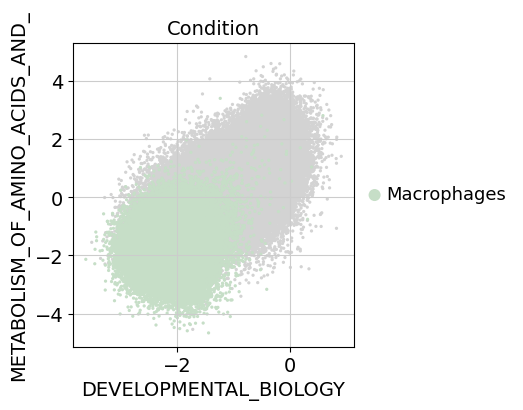

In [315]:
sc.pl.scatter(adata_all, x='DEVELOPMENTAL_BIOLOGY', y='METABOLISM_OF_AMINO_ACIDS_AND_', 
              color='celltype', size=22, title='Condition', groups="Macrophages")

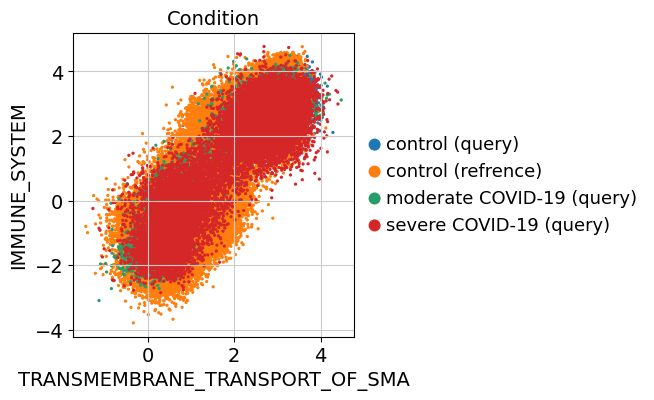

In [310]:
sc.pl.scatter(adata_all, x='TRANSMEMBRANE_TRANSPORT_OF_SMA', y='METABOLISM_OF_LIPIDS_AND_LIPOP', 
              color='condition2', size=22, title='Condition',)

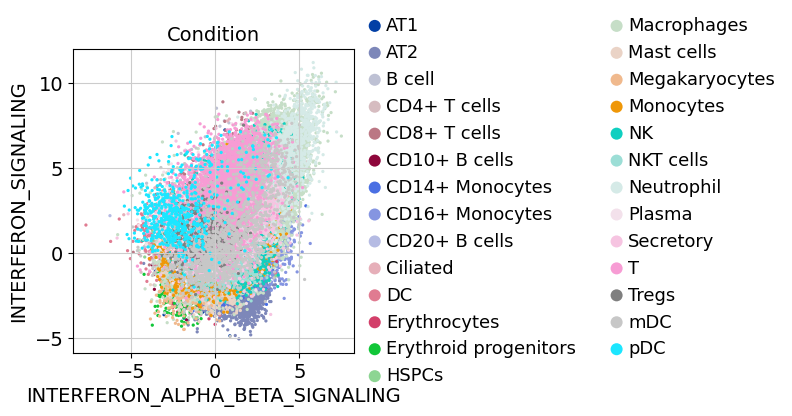

In [226]:
sc.pl.scatter(adata_all, x='INTERFERON_ALPHA_BETA_SIGNALING', y='INTERFERON_SIGNALING', 
              color='condition', size=22, title='Condition')